### Importing the Necessary Libraries

In [2]:
import pandas as pd
import re
import json
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from langdetect import detect, LangDetectException
import contractions
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## 1. Data Preprocessing
### Loading the Data

In [3]:
with open('DB_reddit.json', 'r', encoding='utf-8') as file:
    reddit = json.load(file)

# Converting the data into a DataFrame 
df = pd.DataFrame(reddit)
df.head()


,title,score,date,url,num_comments,comments
0,Not under David Beckhams watch,65534,2023-10-06 17:16:05,https://v.redd.it/0mmzjpgdyisb1,2042,"[Please report rule breaking posts, such as:\n..."
1,David Beckham is not letting this go...,29482,2024-01-02 14:44:45,https://i.redd.it/dowdawvo7y9c1.jpeg,982,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
2,David and Victoria Beckham finally addressing ...,800,2023-10-05 20:46:41,https://v.redd.it/ahnysog1vcsb1,261,[I think if they hadn’t brought this up in a d...
3,Victoria Beckham shares photo of husband David...,2687,2023-12-16 10:45:59,https://i.redd.it/nd35a08lpj6c1.jpeg,298,[Welcome to r/popculturechat! ☺️\n\nAs a proud...
4,Micah Richards on David Beckham,5650,2024-09-19 18:27:36,https://v.redd.it/7o6n7df28qpd1,256,[**Mirrors / Alternative Angles**\n \n\n*I am...


### Check for Missing Values

In [4]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Display missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
title           0
score           0
date            0
url             0
num_comments    0
comments        0
dtype: int64


### Check for Duplicate Values

In [5]:
duplicates = df.duplicated(subset=['url']).sum()
print(f"Number of duplicate rows: {duplicates}")
df.drop_duplicates(subset=['url'], inplace=True)

Number of duplicate rows: 0


### Advance Preprocessing

In [6]:
# Regular expression pattern for detecting URLs
url_pattern = r'http\S+|www\S+|https\S+'

# Function to check for URLs in text
def contains_url(text):
    return bool(re.search(url_pattern, text))

# Check for URLs in the 'title' column
df['Title_Contains_URL'] = df['title'].apply(contains_url)

# Check for URLs in the 'comments' column (handling multiple comments in each row)
df['Comments_Contain_URL'] = df['comments'].apply(lambda comments: any(contains_url(comment) for comment in comments))

# Display rows where URLs are found in either title or comments
urls_in_data = df[(df['Title_Contains_URL']) | (df['Comments_Contain_URL'])]

# Display the results
print(f"Total rows with URLs in title: {df['Title_Contains_URL'].sum()}")
print(f"Total rows with URLs in comments: {df['Comments_Contain_URL'].sum()}")

# Optionally, display the rows that contain URLs
if not urls_in_data.empty:
    print("\nRows containing URLs:")
    print(urls_in_data[['title', 'comments']].head())
else:
    print("\nNo URLs found in the dataset.")


Total rows with URLs in title: 0
Total rows with URLs in comments: 81

Rows containing URLs:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   

                                            comments  
0  [Please report rule breaking posts, such as:\n...  
1  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
2  [I think if they hadn’t brought this up in a d...  
3  [Welcome to r/popculturechat! ☺️\n\nAs a proud...  
4  [**Mirrors / Alternative Angles**\n  \n\n*I am...  


In [7]:
# Function to clean text (already removing URLs)
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9'\s]", '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to detect if the text is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

In [8]:
# Reapply the cleaning function to comments with URLs
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [clean_text(comment) for comment in comments])

# Verify the removal of URLs by checking the updated comments
urls_in_comments_after_removal = df['Cleaned_Comments'].apply(lambda comments: any(re.search(url_pattern, comment) for comment in comments)).sum()
print(f"Total rows with URLs in comments after removal: {urls_in_comments_after_removal}")


Total rows with URLs in comments after removal: 0


In [9]:
# Cleaning and preprocess titles
df['Cleaned_Title'] = df['title'].apply(lambda x: expand_contractions(clean_text(str(x))) if is_english(str(x)) else '')

# Preprocessing each comment within the list
df['Cleaned_Comments'] = df['comments'].apply(lambda comments: [expand_contractions(clean_text(comment)) for comment in comments if is_english(comment)])


### Stopwords Removal

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def process_tokens(tokens):
    # Remove stopwords and lemmatize
    tokens = [word for word in tokens if word not in stop_words]
    # If no tokens are left after stopword removal, return the original tokens
    if not tokens:
        return tokens
    return [lemmatizer.lemmatize(word) for word in tokens]

### Tokenization and Lemmatization

In [11]:
# Tokenize and lemmatize the cleaned text
df['Title_Tokens'] = df['Cleaned_Title'].apply(lambda x: process_tokens(word_tokenize(x)))
df['Comments_Tokens'] = df['Cleaned_Comments'].apply(lambda comments: [process_tokens(word_tokenize(comment)) for comment in comments])

In [12]:
# Display the processed data
processed_columns = ['title', 'Cleaned_Title', 'Title_Tokens', 'comments', 'Cleaned_Comments', 'Comments_Tokens']
print("\nProcessed Data:")
print(df[processed_columns].head(10))


Processed Data:
                                               title  \
0                     Not under David Beckhams watch   
1            David Beckham is not letting this go...   
2  David and Victoria Beckham finally addressing ...   
3  Victoria Beckham shares photo of husband David...   
4                    Micah Richards on David Beckham   
5                                Young David Beckham   
6                         Thoughts on David Beckham?   
7  david beckham: then vs now – is it just me or ...   
8                          David Beckham is autistic   
9  David and Victoria Beckham recreate their wedd...   

                                       Cleaned_Title  \
0                     not under david beckhams watch   
1               david beckham is not letting this go   
2  david and victoria beckham finally addressing ...   
3  victoria beckham shares photo of husband david...   
4                    micah richards on david beckham   
5                             

### Term Frequency

In [13]:
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

def process_text(text, lemmatizer, stopwords_set):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_set]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

term_freq_counter = Counter()

# Processing each row in the DataFrame and updating term frequency counts
for _, row in df.iterrows(): 
    tokens_title = process_text(row['Cleaned_Title'], lemmatizer, stopwords_set)
    tokens_comments = [word for comment in row['Cleaned_Comments'] for word in process_text(comment, lemmatizer, stopwords_set)]

    # Updating term frequency counts
    term_freq_counter.update(tokens_title)
    term_freq_counter.update(tokens_comments)

# Displaying the most common terms
freq_num = 50  
print(f"Top {freq_num} most common terms:")
for term, count in term_freq_counter.most_common(freq_num):
    print(f"{term}: {count}")

Top 50 most common terms:
like: 2620
would: 1826
people: 1739
think: 1396
one: 1357
know: 1190
look: 1124
class: 1110
get: 1087
beckham: 1076
time: 998
really: 913
even: 910
david: 852
good: 840
also: 820
make: 804
year: 799
thing: 780
much: 772
love: 722
still: 702
way: 698
's: 680
never: 671
could: 669
see: 623
working: 618
well: 614
going: 603
money: 598
say: 577
always: 564
lol: 561
got: 559
go: 550
lot: 542
want: 530
right: 517
victoria: 511
work: 510
someone: 506
mean: 505
u: 503
man: 460
said: 459
woman: 459
back: 454
made: 447
though: 444


### Visualize the Top 20 words from term frequency

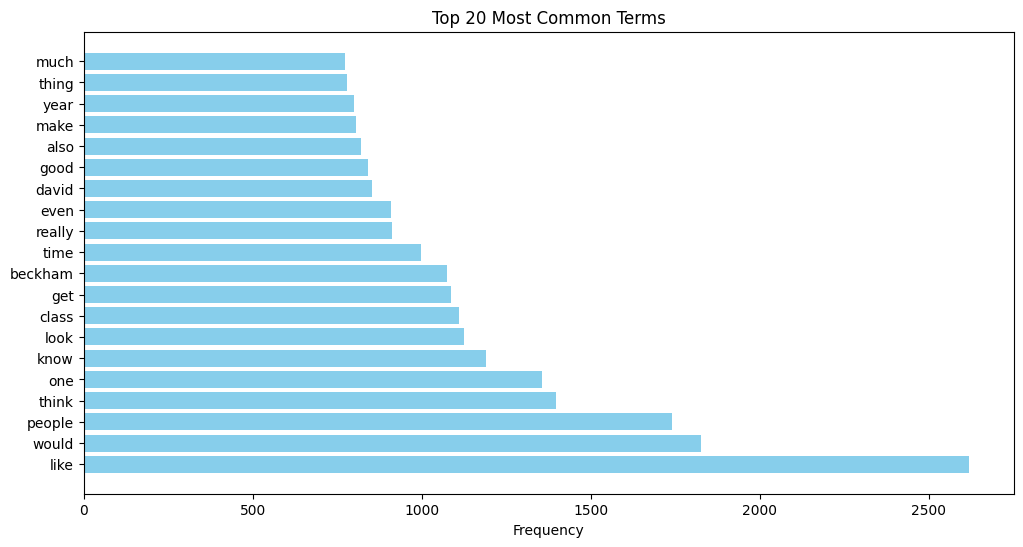

In [14]:
# Getting the most common terms for plotting (top 20)
most_common_terms = term_freq_counter.most_common(20)
terms, counts = zip(*most_common_terms)

# Plotting the term frequency for the top 20 words
plt.figure(figsize=(12, 6))
plt.barh(terms[::-1], counts[::-1], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Terms')
plt.gca().invert_yaxis()  # Invert y axis to have the highest frequency on top
plt.show()


### Wordcloud for Most frequent words

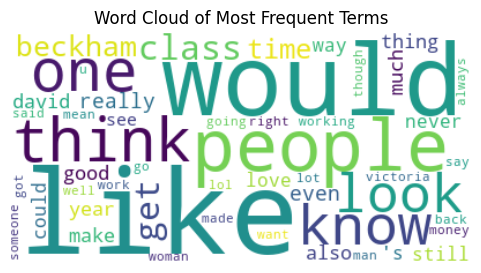

In [15]:
# Create a dictionary of the most common terms and their counts for the WordCloud
word_freq_dict = dict(term_freq_counter.most_common(50))  # You can adjust the number of words to display

# Generate the word cloud
wordcloud = WordCloud(
    width=400, height=200, background_color='white', 
    max_words=200, colormap='viridis'
).generate_from_frequencies(word_freq_dict)

# Plotting the word cloud
plt.figure(figsize=(6, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Frequent Terms')
plt.show()


## 2. Data Modeling
### TF-IDF Vectorization

In [16]:
# Joining the list of comments into a single string for each row
df['Joined_Comments'] = df['Cleaned_Comments'].apply(lambda comments: ' '.join(comments))

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',  
    ngram_range=(1,2),  
    min_df=10,  
    max_df=0.5  
)
# Fitting and transforming the comments into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['Joined_Comments']).toarray()

# Converting the resulting TF-IDF matrix into a DataFrame for readability
tfidf_df = pd.DataFrame(X_tfidf, columns=tfidf_vectorizer.get_feature_names_out())

# Displaying the first few rows of the TF-IDF DataFrame
print(tfidf_df.head())


    ability      able  absolute     abuse    accept    access  according  \
0  0.029979  0.011243  0.017641  0.012243  0.011992  0.020664        0.0   
1  0.000000  0.004884  0.005747  0.000000  0.007813  0.000000        0.0   
2  0.000000  0.017195  0.020235  0.000000  0.000000  0.000000        0.0   
3  0.000000  0.021179  0.000000  0.000000  0.000000  0.000000        0.0   
4  0.000000  0.000000  0.057565  0.000000  0.000000  0.000000        0.0   

    account       act    acting  ...     write     wrote       wtf       yea  \
0  0.005657  0.004410  0.010047  ...  0.005764  0.000000  0.005273  0.010546   
1  0.007371  0.017241  0.000000  ...  0.007511  0.022113  0.000000  0.006871   
2  0.000000  0.010118  0.011525  ...  0.000000  0.000000  0.012097  0.012097   
3  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.059597  0.089395   
4  0.000000  0.057565  0.021857  ...  0.000000  0.024611  0.000000  0.000000   

   year old  years later       yep   younger       yup      ze

### Vader Sentiment Analysis


Comments Sentiment Analysis Results:
                                   Combined_Comments  \
0  please report rule breaking posts such as poli...   
1  welcome to rpopculturechat as a proud bipoc lg...   
2  i think if they had not brought this up in a d...   
3  welcome to rpopculturechat as a proud bipoc lg...   
4  mirrors alternative angles i am a bot and this...   
5  he was fine as hell in his prime like a 6 in p...   
6  the definition of a silver fox zaddy as hell h...   
7  just a note that neither victoria nor david be...   
8  neuro spice was definitly the least understood...   
9  welcome to rpopculturechat as a proud bipoc lg...   

   Comments_Sentiment_Score Comments_Sentiment  
0                    1.0000           positive  
1                    1.0000           positive  
2                    0.9990           positive  
3                    0.9999           positive  
4                    1.0000           positive  
5                    0.9995           positive  
6 

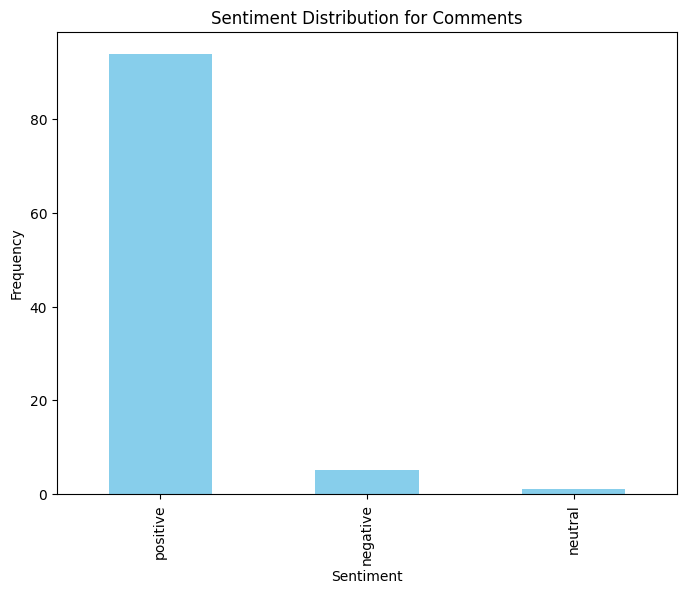

In [17]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if text:  # Ensure the text is not empty
        sentiment = analyzer.polarity_scores(text)
        return sentiment['compound']  
    return 0  

df['Combined_Comments'] = df['Cleaned_Comments'].apply(lambda comments: ' '.join(comments))

df['Comments_Sentiment_Score'] = df['Combined_Comments'].apply(analyze_sentiment)

def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['Comments_Sentiment'] = df['Comments_Sentiment_Score'].apply(categorize_sentiment)

print("\nComments Sentiment Analysis Results:")
print(df[['Combined_Comments', 'Comments_Sentiment_Score', 'Comments_Sentiment']].head(10))

df['Comments_Sentiment'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution for Comments')
plt.show()


### Sentiment Score Distribution

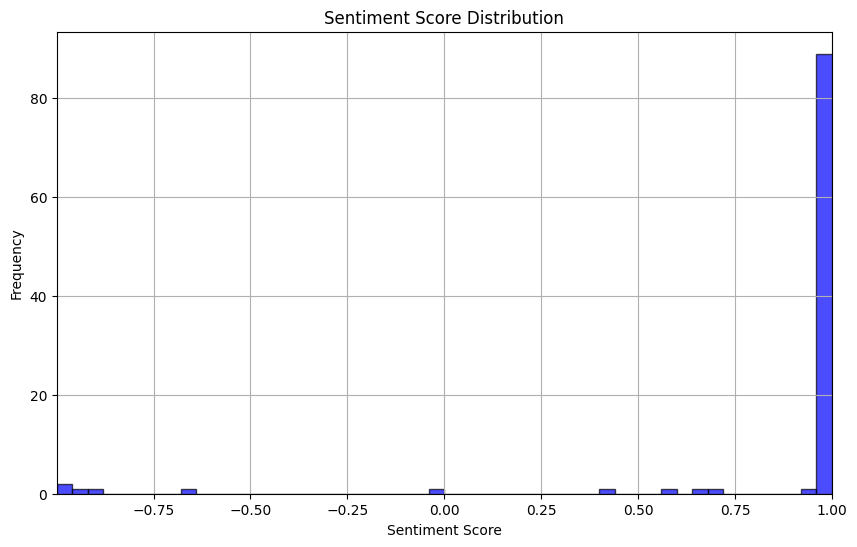

In [18]:
num_bins = 50

# Plotting sentiment score distribution
plt.figure(figsize=(10,6))
plt.hist(df['Comments_Sentiment_Score'], bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
plt.grid(True)  

# Setting plot titles and labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')

# Setting x and y limits
plt.xlim(df['Comments_Sentiment_Score'].min(), df['Comments_Sentiment_Score'].max())
plt.ylim(0, plt.ylim()[1])  # Ensuring y-axis starts from 0 and is correctly scaled

plt.show()


### Density plot

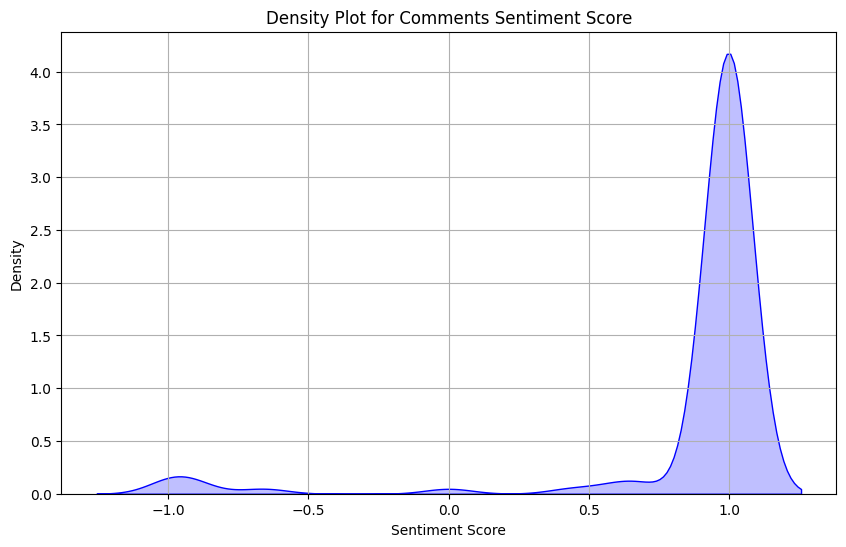

In [19]:
# Plot the density of the sentiment scores
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Comments_Sentiment_Score'], fill=True, color='blue', bw_adjust=0.5)
plt.title('Density Plot for Comments Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.grid(True)  # For better readability
plt.show()

### Wordcloud for most frequent terms in all comments

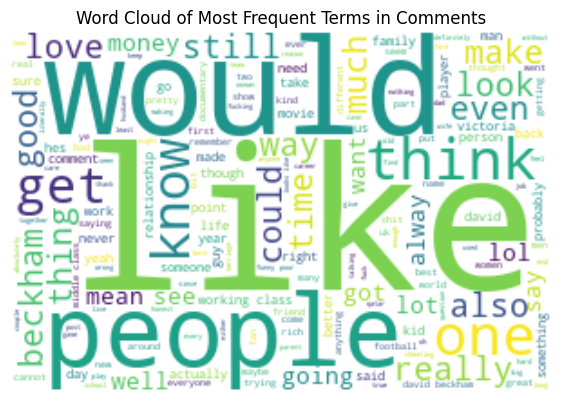

In [20]:
all_comments = ' '.join(df['Combined_Comments'])

wordcloud = WordCloud(
    width=300, height=200, background_color='white', 
    max_words=500, colormap='viridis', stopwords=set(stopwords.words('english'))
).generate(all_comments)

plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Frequent Terms in Comments')
plt.show()


## 3. Topic Modeling
### LDA Modeling with Gensim

In [33]:
df['Comments_Tokens'] = df['Comments_Tokens'].apply(lambda x: [str(i) for i in x] if isinstance(x, list) else [])

tokenized_comments = df['Comments_Tokens'].tolist()
id2word = corpora.Dictionary(tokenized_comments)

corpus = [id2word.doc2bow(text) for text in tokenized_comments]

num_topics = 5
lda_model_gensim = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True,
    minimum_probability=0.01
)

num_words_per_topic = 5
print("Gensim LDA Model Topics:")
for idx, topic in lda_model_gensim.print_topics(num_topics=num_topics, num_words=num_words_per_topic):
    print(f"Topic {idx}:")
    for word in topic.split(" + "):
        print(f"\t{word}")
    print("\n")

coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=tokenized_comments, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

Gensim LDA Model Topics:
Topic 0:
	0.003*"[]"
	0.000*"['welcome', 'rpopculturechat', 'proud', 'bipoc', 'lgbtq', 'womandominated', 'space', 'sub', 'civil', 'discussion', 'know', 'begin', 'start', 'participating', 'sip', 'spill', 'daily', 'discussion', 'thread', 'bully', 'bigotry', '99941279999994127998999412799799941279969994127995127987650398205127752127987650398205989565039', 'please', 'read', 'respect', 'rule', 'check', 'wiki', 'question', 'modmail', 'always', 'open', 'bot', 'action', 'performed', 'automatically', 'please', 'contact', 'moderator', 'subredditmessagecomposetorpopculturechat', 'question', 'concern']"
	0.000*"['thank']"
	0.000*"['would', 'surprised', 'whole', 'bit', 'semi', 'scripted', 'make', 'beckham', 'seem', 'earth', 'selling', 'qatar']"
	0.000*"['money']"


Topic 1:
	0.003*"[]"
	0.001*"['love']"
	0.001*"['bend', 'knee']"
	0.001*"['mostly', 'know', 'skinny', 'neck']"
	0.001*"['welcome', 'rpopculturechat', 'proud', 'bipoc', 'lgbtq', 'womandominated', 'space', 'sub', '

### Scikit-Learn LDA Model with CountVectorizer


In [51]:
df['Combined_Comments'] = df['Cleaned_Comments'].apply(lambda comments: ' '.join(comments))

vectorizer = CountVectorizer(
    max_df=0.9,  # Ignore terms that appear in more than 90% of the documents
    min_df=10,   # Ignore terms that appear in less than 10 documents
    stop_words='english',  # Remove stopwords
    ngram_range=(1, 2)  # Unigrams and bigrams
)

dtm = vectorizer.fit_transform(df['Combined_Comments'])

lda_model_sklearn = LatentDirichletAllocation(n_components=10, random_state=100)
lda_model_sklearn.fit(dtm)

def display_topics(model, feature_names, num_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        words = " ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]])
        topics.append(words)
        print(f"Topic {topic_idx}:")
        print(words)
        print("\n")
    return topics

feature_names = vectorizer.get_feature_names_out()
num_top_words = 20  # Number of top words per topic to display
print("LDA Model Topics:")
topics = display_topics(lda_model_sklearn, feature_names, num_top_words)

LDA Model Topics:
Topic 0:
people qatar money does football world club hes time david probably really care way right point say going want make


Topic 1:
people women really does harry good comment body time spice woman victoria make dress years seen sub thought said power


Topic 2:
men relationship women people man love woman does way marriage married person cheating really time life want relationships partner husband


Topic 3:
player good players football right team game time ball best played really united better goal play england rooney way got


Topic 4:
automatically action bot performed automatically bot action questions concerns contact moderators action performed automatically contact concerns questions moderators contact performed comment removed huge unfortunately old info


Topic 5:
love david people time really victoria does lol good got documentary way years family said spice going remember sure lot


Topic 6:
class working working class people middle rich middle class m

### Label the topics with meaningful titles

In [50]:
topic_titles = {
    0: "David Beckham's Football Career and Qatar Influence",
    1: "Public Perception of Harry and Victoria Beckham",
    2: "David and Victoria Beckham's Relationship and Family Life",
    3: "Football Players and Their Performance on the Field",
    4: "Automated Actions and Moderation in Online Discussions",
    5: "Public Opinions on David and Victoria Beckham's Public Image",
    6: "Class and Economic Status in Society",
    7: "David Beckham's Style and Public Image Over the Years",
    8: "Family and Parenting in the Beckham Household",
    9: "David Beckham's Media and Public Representation"
}

print("\nAllocated Topic Titles:")
for idx, topic_words in enumerate(topics):
    print(f"Topic {idx}: {topic_titles[idx]}")
    print(topic_words)
    print("\n")


Allocated Topic Titles:
Topic 0: David Beckham's Football Career and Qatar Influence
people qatar money does football world club hes time david


Topic 1: Public Perception of Harry and Victoria Beckham
people women really does harry good comment body time spice


Topic 2: David and Victoria Beckham's Relationship and Family Life
men relationship women people man love woman does way marriage


Topic 3: Football Players and Their Performance on the Field
player good players football right team game time ball best


Topic 4: Automated Actions and Moderation in Online Discussions
automatically action bot performed automatically bot action questions concerns contact moderators action performed automatically contact concerns


Topic 5: Public Opinions on David and Victoria Beckham's Public Image
love david people time really victoria does lol good got


Topic 6: Class and Economic Status in Society
class working working class people middle rich middle class money rolls really


Topic 7: Da

### Wordcloud for each topic

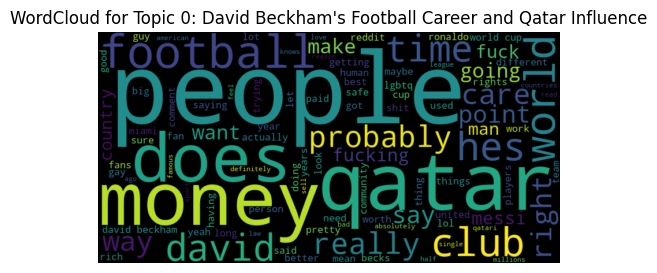

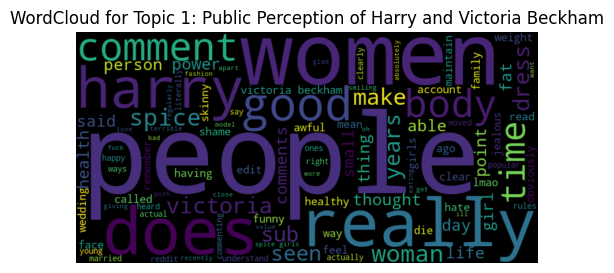

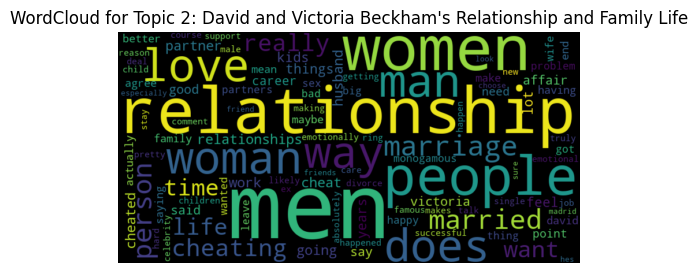

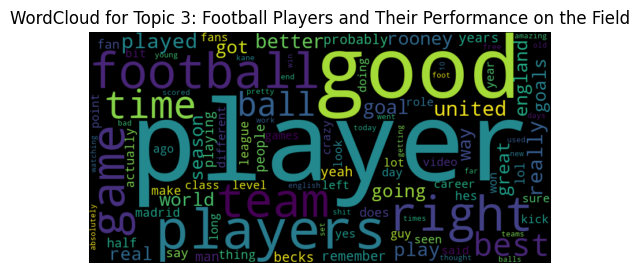

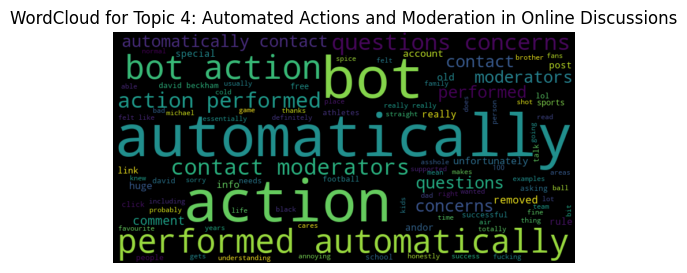

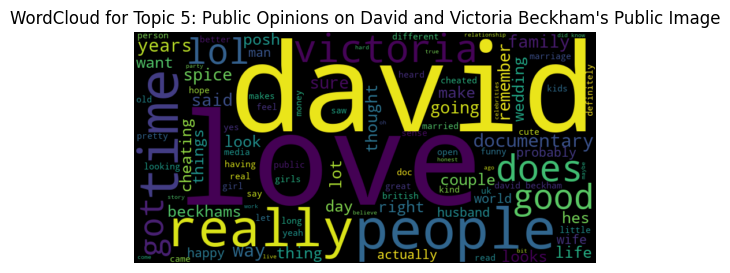

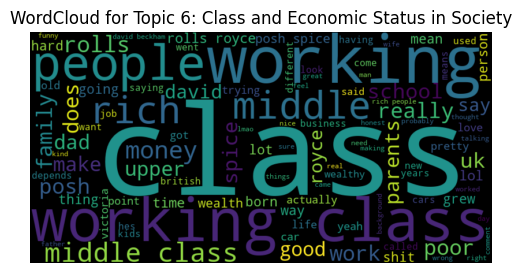

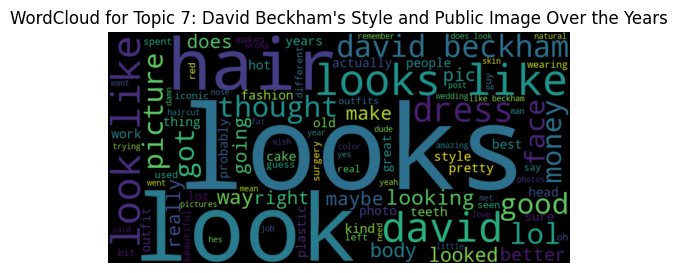

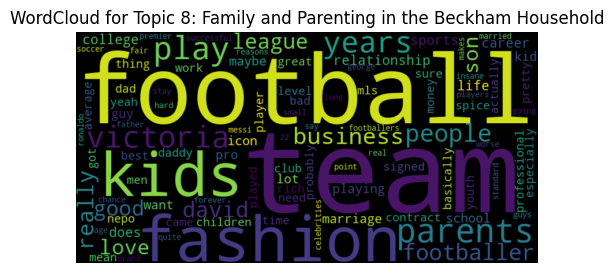

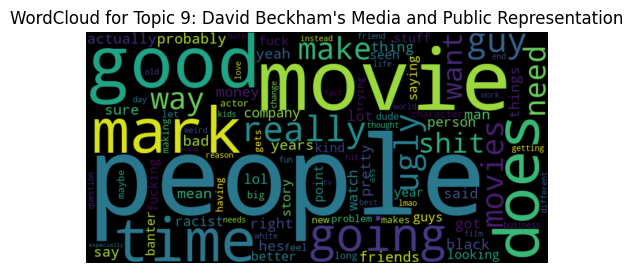

In [53]:
def plot_wordcloud_for_topic(topic_idx, topic_words, feature_names, num_words=100):
    # Get the top words and their weights for the topic
    top_words = {feature_names[i]: topic_words[i] for i in topic_words.argsort()[:-num_words - 1:-1]}
    
    wordcloud = WordCloud(
        width=800, height=400, background_color='black'
    ).generate_from_frequencies(top_words)
    
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"WordCloud for Topic {topic_idx}: {topic_titles.get(topic_idx, 'Unknown Topic')}")
    plt.axis("off")
    plt.show()

feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_model_sklearn.components_):
    plot_wordcloud_for_topic(topic_idx, topic, feature_names, num_words=100)